# Allstate EDA

## Import

In [1]:
from __future__ import division
import gc
import numpy as np
np.set_printoptions(suppress = True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

c:\python27x64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading data

In [2]:
dir_path = '../input/'
train_df = pd.read_csv(dir_path + 'train.csv', sep = ',', header = 0, low_memory = False, nrows = None)
test_df = pd.read_csv(dir_path + 'test.csv', sep = ',', header = 0, nrows = None)
subm_df = pd.read_csv(dir_path + 'sample_submission.csv', sep = ',', header = 0, nrows = None)

## Basic characteristics of the datasets

Shape, test/train ratio, memory usage, duplicated observations, NaNs, negative values, train/test consistency, data types of features.

* Data is not so big
* But we have not so small number of features, so if we would using interactions in some algorithm it may be memory and time consuming
* test/train ratio is 0.67
* There are no duplicated observations in data
* There are no NaNs, so no need to think about imputation
* There are no negatives, so we can use statistical tests like chi2
* Train and test are consistent (have the same features)
* We have 'object' (categorical) features, so we would need to apply transformation (e.g. LabelEncoder, OneHotEncoder)

In [3]:
# Shape
print('Train shape: %d rows, %d cols' % train_df.shape)
print('Test shape:  %d rows, %d cols' % test_df.shape)
print('~' * 2 ** 6 + '>')
# test/train ratio
print('test/train ratio: %.2f' % (test_df.shape[0] / train_df.shape[0]))
print('~' * 2 ** 6 + '>')
# Memory usage
print('Train memory usage: %.3f MiB' % (train_df.memory_usage(index = True).sum() / (2 ** 20) ))
print('Test  memory usage: %.3f MiB' % (test_df.memory_usage(index = True).sum() / (2 ** 20) ))
print('~' * 2 ** 6 + '>')
# Duplicated observations
print('Duplicated observations in train: %s' % train_df.duplicated().any())
print('Duplicated observations in test:  %s' % test_df.duplicated().any())
print('~' * 2 ** 6 + '>')
# NaNs
print('NaNs in train: %s' % train_df.isnull().mean().any())
print('NaNs in test:  %s' % test_df.isnull().mean().any())
print('~' * 2 ** 6 + '>')
# Negative values
print('Negative values in train: %s' % (train_df < 0).mean().any())
print('Negative values in test:  %s' % (test_df < 0).mean().any())
print('~' * 2 ** 6 + '>')
# Train/test consistency
train_columns_set = set(train_df.columns.tolist())
test_columns_set = set(test_df.columns.tolist())
# Column name should match in train and test except target column
# So we subtract sets and in result we want to see our target column, that would mean that data is consistent
print('Differens between column sets: %s' % list(train_columns_set - test_columns_set))
print('~' * 2 ** 6 + '>')
# Data types
print('Train data types:\n\n%s' % train_df.dtypes.value_counts())
print('\nTest data types:\n\n%s' % test_df.dtypes.value_counts())

Train shape: 188318 rows, 132 cols
Test shape:  125546 rows, 131 cols
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
test/train ratio: 0.67
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Train memory usage: 189.651 MiB
Test  memory usage: 125.477 MiB
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Duplicated observations in train: False
Duplicated observations in test:  False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
NaNs in train: False
NaNs in test:  False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Negative values in train: False
Negative values in test:  False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Differens between column sets: ['loss']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Train data types:

object     116
float64     15
int64        1
dtype: int64

Test data types:

object     116
float64     14
int64        1
dtype: int64


## Look at data

In [4]:
print(train_df.head())

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  

## Prepare column lists

In [5]:
id_col = 'id'
y_col = 'loss'
all_cols = train_df.columns.tolist()
all_cols.remove(id_col)
all_cols.remove(y_col)
obj_cols = train_df.dtypes[train_df.dtypes == 'object'].index.tolist()
num_cols = list(set(all_cols) - set(obj_cols))
num_cols.sort(key = lambda x: '{0:0>6}'.format(x)) # sort

print('We have %d numeric columns' % len(num_cols))
print('~' * 2 ** 6 + '>')
print(num_cols)
print('\nWe have %d categorical columns' % len(obj_cols))
print('~' * 2 ** 6 + '>')
print(obj_cols)

We have 14 numeric columns
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']

We have 116 categorical columns
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 

## Basic statistical characteristics and skew of numerical features

We can see that all numerical features (both in train and in test) are already passed some preprocessing, have no outliers, and have no substantial skew.

For both train and test:

* interval [0, 1]
* mean around 0.5
* std around 0.2
* the most  skewed feature: cont9 (1.072429) (1.059535)
* the least skewed feature: cont3 (0.010002) (0.002553)

In [6]:
# Train
# Statistics
print('Statistics (train):\n')
print(train_df[num_cols].describe())
print('~' * 2 ** 6 + '>')
# Skew
print('Skew (train) (sorted from highest to lowest absolute value):\n')
print(np.abs(train_df[num_cols].skew()).sort_values(ascending = False))

Statistics (train):

               cont1          cont2          cont3          cont4  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.493861       0.507188       0.498918       0.491812   
std         0.187640       0.207202       0.202105       0.211292   
min         0.000016       0.001149       0.002634       0.176921   
25%         0.346090       0.358319       0.336963       0.327354   
50%         0.475784       0.555782       0.527991       0.452887   
75%         0.623912       0.681761       0.634224       0.652072   
max         0.984975       0.862654       0.944251       0.954297   

               cont5          cont6          cont7          cont8  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.487428       0.490945       0.484970       0.486437   
std         0.209027       0.205273       0.178450       0.199370   
min         0.281143       0.012683       0.069503       0.236880   
25%         

In [7]:
# Test
# Statistics
print('Statistics (test):\n')
print(test_df[num_cols].describe())
print('~' * 2 ** 6 + '>')
# Skew
print('Skew (test) (sorted from highest to lowest absolute value):\n')
print(np.abs(test_df[num_cols].skew()).sort_values(ascending = False))

Statistics (test):

               cont1          cont2          cont3          cont4  \
count  125546.000000  125546.000000  125546.000000  125546.000000   
mean        0.494447       0.506939       0.498255       0.492334   
std         0.187961       0.206837       0.201746       0.210815   
min         0.000016       0.001149       0.002634       0.176921   
25%         0.347403       0.358319       0.336963       0.327354   
50%         0.475784       0.555782       0.527991       0.452887   
75%         0.626630       0.681761       0.634224       0.652072   
max         0.984975       0.862654       0.944251       0.956046   

               cont5          cont6          cont7          cont8  \
count  125546.000000  125546.000000  125546.000000  125546.000000   
mean        0.487640       0.492188       0.485945       0.487401   
std         0.209119       0.205574       0.178650       0.199549   
min         0.281143       0.012683       0.069503       0.236880   
25%         0

## Plot some numeric features

We can see that distributions of the same features in train and test are almost identical. It was already suggested by statistics above.

c:\python27x64\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


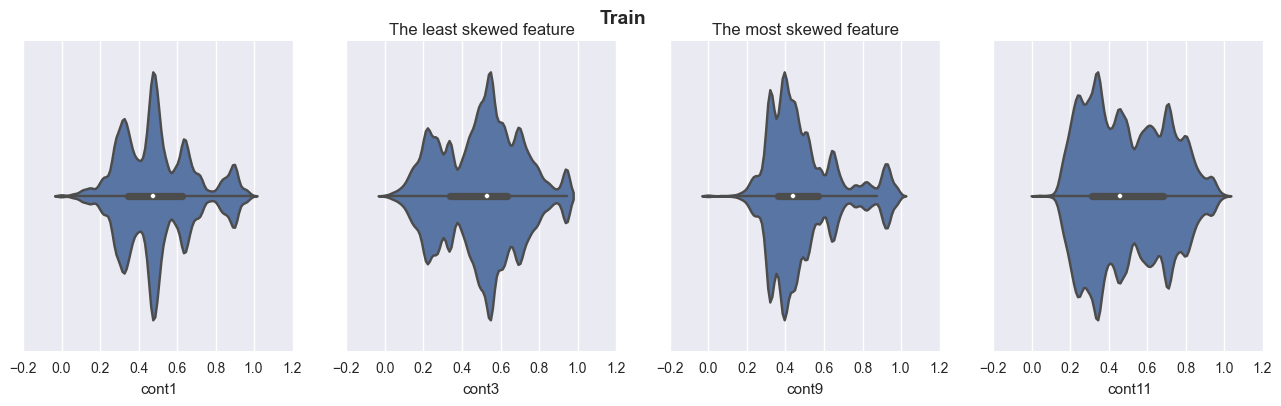

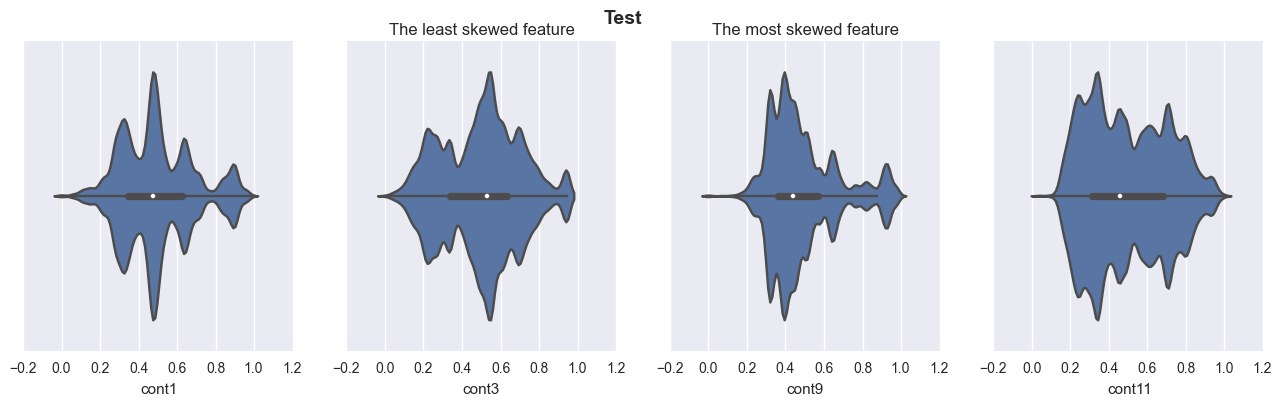

In [8]:
# Train
fig = plt.figure(1, figsize=(16, 4))
fig.suptitle('Train', fontsize = 14, fontweight = 'bold')

plt.subplot(141)
sns.violinplot(train_df.cont1)
plt.subplot(142)
sns.violinplot(train_df.cont3)
plt.title('The least skewed feature')
plt.subplot(143)
sns.violinplot(train_df.cont9)
plt.title('The most skewed feature')
plt.subplot(144)
sns.violinplot(train_df.cont11)

# Test
fig = plt.figure(2, figsize=(16, 4))
fig.suptitle('Test', fontsize = 14, fontweight = 'bold')

plt.subplot(141)
sns.violinplot(test_df.cont1)
plt.subplot(142)
sns.violinplot(test_df.cont3)
plt.title('The least skewed feature')
plt.subplot(143)
sns.violinplot(train_df.cont9)
plt.title('The most skewed feature')
plt.subplot(144)
sns.violinplot(train_df.cont11)

plt.show()

## Categorical features

We will count number of unique values for each column for train and test.  
We will also find difference (and percentage of difference) in numbers of unique values for train and test. This will help us to approach conversion of categories to numbers.  

In [9]:
# Prepare empty DataFrame
c = ['col_name', 'num_uniqe_train', 'num_uniqe_test', 'mismatch', 'percentage_mismatch']
unique_df = pd.DataFrame(np.zeros((len(obj_cols), len(c))).astype(int), columns = c)
# Count uniques
for i in range(len(obj_cols)):
    col_name = obj_cols[i]
    num_uniqe_train = len(np.unique(train_df[col_name]))
    num_uniqe_test = len(np.unique(test_df[col_name]))
    mismatch = num_uniqe_train - num_uniqe_test
    percentage_mismatch = np.round(np.abs(mismatch) / num_uniqe_train, 2)
    unique_df.iloc[i] = (col_name, num_uniqe_train, num_uniqe_test, mismatch, percentage_mismatch)

## Look at number of unique categorical values

* Lager part of features (72) has only two distinct categories
* Some features has large number of distinct categories

In [10]:
# Group by number of uniques
groupby_df = unique_df[['col_name', 'num_uniqe_train']].groupby('num_uniqe_train').count()
groupby_df.reset_index(inplace = True)
groupby_df.columns = ['num_uniqe_train', 'count']
print(groupby_df)

    num_uniqe_train  count
0                 2     72
1                 3      4
2                 4     12
3                 5      3
4                 7      4
5                 8      3
6                 9      1
7                11      1
8                13      1
9                15      1
10               16      2
11               17      2
12               19      2
13               20      2
14               23      1
15               51      1
16               61      1
17               84      1
18              131      1
19              326      1


## Look at features where numbers of unique values are mismatched

We can see that only **14** features has mismatched number of categories, and percentages of mismatch are relatively low.  
This means that we can start without any correction of mismatch, e.g we can combine all unique values from train and test and encode with LabelEncoder or OneHotEncoder.

In [11]:
print(unique_df[unique_df.mismatch != 0])

    col_name  num_uniqe_train  num_uniqe_test  mismatch  percentage_mismatch
89     cat90                7               6         1                 0.14
91     cat92                7               8        -1                 0.14
95     cat96                8               9        -1                 0.12
98     cat99               16              17        -1                 0.06
100   cat101               19              17         2                 0.11
101   cat102                9               7         2                 0.22
102   cat103               13              14        -1                 0.08
104   cat105               20              18         2                 0.10
105   cat106               17              18        -1                 0.06
108   cat109               84              74        10                 0.12
109   cat110              131             123         8                 0.06
112   cat113               61              60         1                 0.02

# Train/test distribution consistency test

We want to use cross-validation technique to score our models.  
To be able to get reliable cross-validation scores, assumption about identical distributions for train and test sets must hold.
To check if it's true (i.e. to check if train and test are drawn from the same distribution), we can use simple approach:

* Label all observations in train as '0', and all observations in test as '1'
* Combine train and test sets
* Randomly draw new_train and new_test sets
* Fit classification model with new_train, and try to classify new_test
* If classifier fails to distinguish train and test observations, that means that initial train and test are identically distributed

As we can see below ROC score is **0.502166**. It means that classifier didn't manage to distinguish train and test observations from initial datasets. So we can say that distributions of initial train and test sets are **very similar**.

In [12]:
# Creating 'loss' column in test set to simplify concatenation
test_df.loc[:, 'loss'] = 0

# Mark train observations as "0" and test observations as "1"
train_df.loc[:, 'flag'] = 0
test_df.loc[:, 'flag'] = 1

# Combine train and test sets
r, c = train_df.shape
tt_df = pd.concat([train_df, test_df], ignore_index = True)

# Factorize categorical variables
for col in obj_cols:
    tt_df.loc[:, col] = pd.factorize(tt_df[col], sort = True)[0]
    
# Get ndarrays
X = tt_df[num_cols + obj_cols].values
y = tt_df['flag'].values

# We don't need combined DataFrame any more
del tt_df
gc.collect()

# Create new train and new test set to perform classification
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size = r, random_state = 0)

print(X_tr.shape)
print(X_te.shape)

(188318L, 130L)
(125546L, 130L)


In [13]:
# Perform classification using XGBoost
model = XGBClassifier(seed = 0, n_estimators = 100)
model = model.fit(X_tr, y_tr)
y_pred = model.predict_proba(X_te)[:, 1]

auc = roc_auc_score(y_te, y_pred)
print('AUC: %.6f' % auc)

AUC: 0.502166


## Basic statistical characteristics and skew of target variable

* Target is skewed, so it needs preprocessing
* Probably, log transform would be appropriate

In [14]:
# Initial target
# Statistical characteristics
print('Statistics (initial):\n')
print(train_df.loss.describe())
print('~' * 2 ** 6 + '>')
# Skew
print('Skew (initial): %.6f' % train_df.loss.skew())
print('\n')

# Log transformed target
# Statistical characteristics
print('Statistics (log transformed):\n')
print(np.log(train_df.loss).describe())
print('~' * 2 ** 6 + '>')
# Skew
print('Skew (log transformed): %.6f' % np.log(train_df.loss).skew())

Statistics (initial):

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Skew (initial): 3.794958


Statistics (log transformed):

count    188318.000000
mean          7.685268
std           0.811868
min          -0.400478
25%           7.093787
50%           7.657080
75%           8.259470
max          11.703647
Name: loss, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~>
Skew (log transformed): 0.092975


## Plot initial and log transformed target

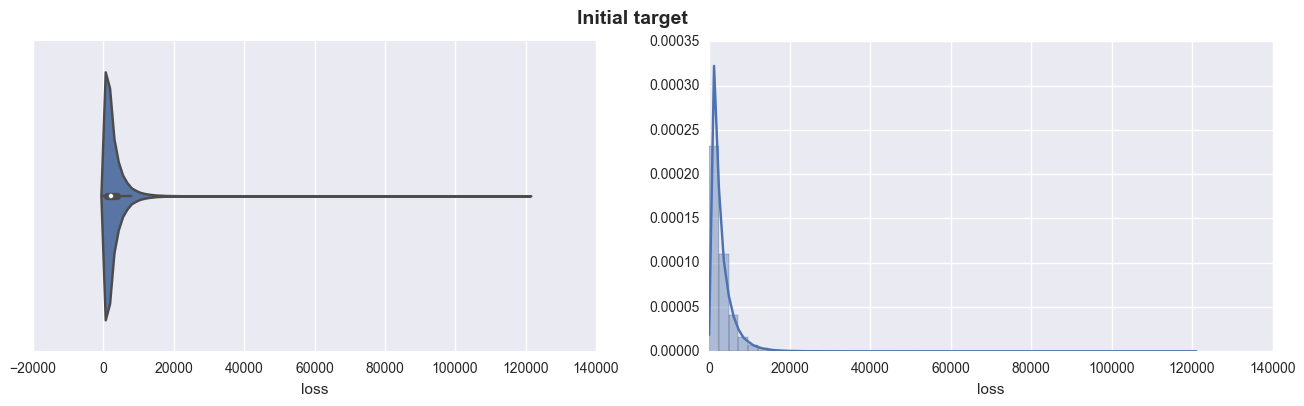

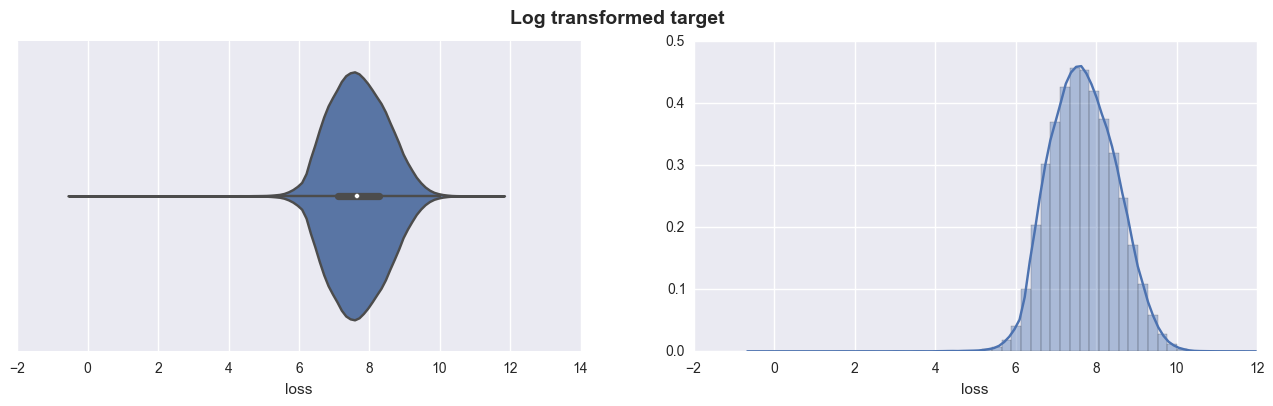

In [15]:
fig = plt.figure(1, figsize=(16, 4))
fig.suptitle('Initial target', fontsize = 14, fontweight = 'bold')

plt.subplot(121)
sns.violinplot(train_df.loss)
plt.subplot(122)
sns.distplot(train_df.loss)

fig = plt.figure(2, figsize=(16, 4))
fig.suptitle('Log transformed target', fontsize = 14, fontweight = 'bold')

plt.subplot(121)
sns.violinplot(np.log(train_df.loss))
plt.subplot(122)
sns.distplot(np.log(train_df.loss))

plt.show()

## Pair-wise correlations (Pearson) between numerical features, between each numerical feature and target
Heatmap is a very efficient representation of pair-wise characteristics.

We can see, that some features has high correlation, e.g.:

* cont11 & cont12 (0.99)
* cont1 & cont9 (0.93)

Correlation with target:

* Highest correlation with target: cont2 (0.14)
* Lowest correlation with target: cont13 (0.004)

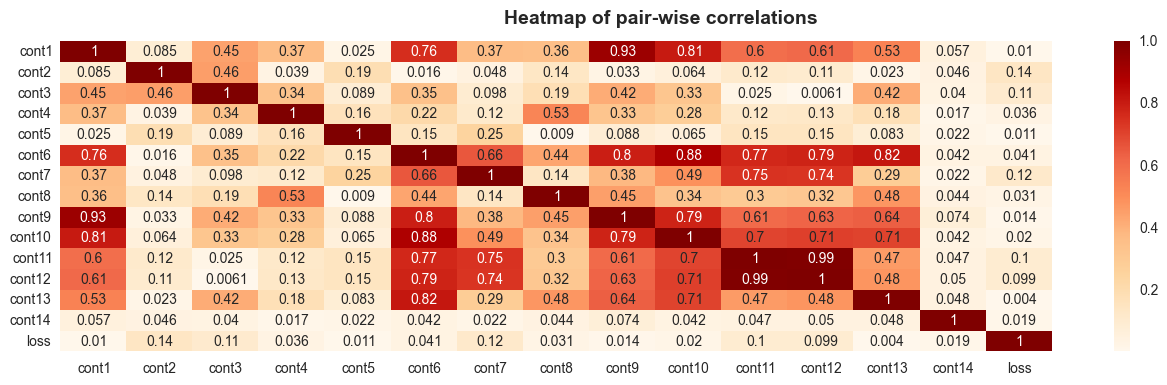

In [16]:
pairwise_corr = train_df[num_cols + [y_col]].corr().abs()

# Plot heatmap
fig = plt.figure(1, figsize=(16, 4))
fig.suptitle('Heatmap of pair-wise correlations', fontsize = 14, fontweight = 'bold')
plt.subplot(111)
sns.heatmap(pairwise_corr, annot = True, cmap = 'OrRd')
dump = plt.plot()

***

## Overall conclusion

* Numerical features are already preprocessed for us
* Mismatch in categorical values isn't very substantial. So we can start from simple factorization through combined train and test
* Distributions of train and test features are very similar. So we can heavily rely on cross-validation
* Target is skewed, so preprocessing (log) is needed
